In [1]:
#import module (library)

import pandas as pd
import pycaret
import numpy as np
import math
import matplotlib.pyplot as plt
from pycaret.regression import *

from pycaret.regression import load_model

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

import time
import datetime

# import module (user defined function)

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *
from py_module.pre_processing import *
from py_module.verify import *
from py_module.etc import *
from py_module.compare import *

In [2]:
# === initial setting ===

parameter = "Llt" # target parameter

In [3]:
# === import raw_data (from csv file) ===

# csv format 시뮬레이션 데이터로부터 데이터 import

## - opt
# pp : outlier data 제거 여부, 제거시 1 설정 (default : None)
# size_en : 데이터 잘라내기 활성화 (default : False)
# size : 데이터 크기 (default : 100000)

filename = "./Data_2021_10_14_v1 (N98923)/Data.csv" # csv file directory and name

raw_data = load_data(fn=filename, pp=1, size_en=False, size=10000)

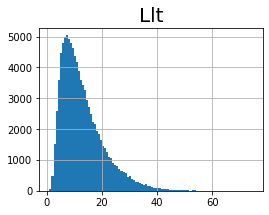

In [4]:
# === plot raw_data histogram (for data pre-process / option-task) ===

# raw_data의 각 파라미터 분포 확인

## - parameter
# input : N1, N2, d1, d2, freq, move_tx, move_rx, offset_tx, offset_rx, per, space1, space2, space3, space4, l1, l2, h1, w1
# output : Lmt, Lmr, Llt, Llr, k, R1, R2

## - input
# raw_data : 전체 data
# parameter : 확인을 원하는 parameter 이름

## - opt
# bins : histogram bins 갯수 (default : 100)
# plt_size : plot의 출력 사이즈 (default : [6,5])
# grid_en : gird 활성화 (default : False)
# title_en : title 활성화 (default : False)
# title : title 출력 내용 (default : "")
# fontsize : plot 글자 크기 (default : {}) (see detail : https://www.delftstack.com/ko/howto/matplotlib/how-to-set-the-figure-title-and-axes-labels-font-size-in-matplotlib/)

par = "Llt" # desired parameter as a histogram
title = parameter # plot title name
fontsize = {'axes.titlesize' : 20, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10}

plot_histogram(raw_data, par, plt_size=[4,3], grid_en=True, title_en=True, title=title, fontsize=fontsize)

In [5]:
# === dataset pre-processing ===

# import한 raw_data를 pre-processing 해주는 작업

# 1. drop output data except for target output
# 학습을 원하는 parameter만 남기고 나머지 output 제거

processed_data = drop_output(raw_data, parameter)



# 2. cut data
# outlier 제거를 위해 데이터를 지정한 범위 내의 값만 남김 (위의 plot data 프로세스 결과를 참조하여 범위 지정)

## - opt
# lo : lower bound value (default : -inf)
# hi : upper bound value (default : inf)

processed_data = cut_data(processed_data, parameter=parameter, lo=0.1, hi=40)



# 3. add feature
# 기존에 존재하는 input parameter들을 이용해서 물리적인 의미를 갖는 새로운 파라미터를 만들어 낼 시 모델의 성능을 증가시킬 수 있음
# ex> 변압기 자화 인덕턴스는 턴수의 제곱에 비례하므로 턴수의 제곱에 해당하는 파라미터를 새로 만들어 자화인덕터 regression 모델을 만들 경우 모델 성능 증가

new_feature_names = []

processed_data = add_feature(processed_data, parameter=parameter, new_feature_names = new_feature_names)


# 학습에 사용할 최종 데이터
processed_data



# TO DO LIST
# normalize 추가


,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Llt
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,6.704324
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,13.703235
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,19.559244
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,16.173505
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,35.181363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97610,9,9,8.4,9.2,42000.0,7,2,8,-14,2483,9,59,9,35,30,71,235,105,14.449801
97611,5,5,11.4,8.9,25000.0,3,4,12,-6,1838,2,50,3,47,23,62,161,118,7.164551
97612,5,5,8.6,9.6,25000.0,2,2,17,-2,4913,1,21,3,35,29,51,110,80,3.697227
97613,5,5,11.0,3.6,25000.0,1,7,18,-12,4437,1,33,4,31,26,59,131,170,8.532143


In [6]:
# === algorithm compare ===

# 모델 학습에 적합한 알고리즘을 찾기 위해 여러 알고리즘들을 모두 학습하여 성능을 비교

# activate logger
[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)

algorithm_list = models().index # pycaret 라이브러리의 모든 regression 알고리즘 리스트
except_list = ["kr","svm"] # 비교하지 않을 알고리즘 리스트
low_list = ["et","rf","dt"] # num_itr을 적게 가져갈 알고리즘 리스트

# except list의 알고리즘을 리스트에서 제거
for al_name in except_list :
    algorithm_list = algorithm_list[algorithm_list!=al_name]

# - opt
# parameter : target parameter (default : None)
# data : dataset (default : None)
# algorithm_list : 비교할 알고리즘 리스트 (default : [])
# low_list : num_itr을 적게 가져갈 알고리즘 리스트
# tune_en : 튜닝 진행여부 (default : False)
# n_h : num_itr (default : 100)
# n_l : low_list의 알고리즘들의 num_itr (default : 50)
# optimize : 튜닝시 기준이되는 성능지표 (default : MAE)
# seach_library : 튜닝 라이브러리 (default : "scikit-learn")
# search_algorithm : 튜닝 알고리즘 (default : "random")

compare_algorithm(parameter=parameter, data=processed_data, algorithm_list=algorithm_list, low_list=low_list, tune_en=True, n_h=1000, n_l=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.1765,9.6480,3.1061,0.8164,0.2078,0.1821
1,2.3026,10.8796,3.2984,0.7944,0.2133,0.1879
2,2.3168,10.7716,3.2820,0.8037,0.2137,0.1892
3,2.2398,10.2524,3.2019,0.7989,0.2136,0.1877
4,2.2840,10.3009,3.2095,0.8029,0.2115,0.1888
5,2.3295,11.0947,3.3309,0.7856,0.2148,0.1903
6,2.2602,10.2439,3.2006,0.8067,0.2114,0.1869
7,2.2948,10.6658,3.2659,0.7936,0.2138,0.1898
8,2.2810,10.7363,3.2766,0.7947,0.2141,0.1904
9,2.2993,10.6518,3.2637,0.8038,0.2150,0.1889


IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:43:32
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 45.4min


In [ ]:
# === regression data ===

# processed_data를 이용하여 regression 모델을 만드는 작업 수행

## - opt
# algorithm : regression algorithm (default : "ligthgbm")
# frac_ratio : train set / test set ratio (default : 0.9)
# silent : (default : True)
# save_en : whether to save the trained model as a file (.pkl) : (default : False)
# save_model_name : model file name : (default : "model")
# new_feature_names : to avoid number of features error (default : [])

## - algorithm list (see detail : https://pycaret.readthedocs.io/en/latest/api/regression.html)
# 'lr' - Linear Regression
# 'lasso' - Lasso Regression
# 'ridge' - Ridge Regression
# 'en' - Elastic Net
# 'lar' - Least Angle Regression
# 'llar' - Lasso Least Angle Regression
# 'omp' - Orthogonal Matching Pursuit
# 'br' - Bayesian Ridge
# 'ard' - Automatic Relevance Determination
# 'par' - Passive Aggressive Regressor
# 'ransac' - Random Sample Consensus
# 'tr' - TheilSen Regressor
# 'huber' - Huber Regressor
# 'kr' - Kernel Ridge
# 'svm' - Support Vector Regression
# 'knn' - K Neighbors Regressor
# 'dt' - Decision Tree Regressor
# 'rf' - Random Forest Regressor
# 'et' - Extra Trees Regressor
# 'ada' - AdaBoost Regressor
# 'gbr' - Gradient Boosting Regressor
# 'mlp' - MLP Regressor
# 'xgboost' - Extreme Gradient Boosting
# 'lightgbm' - Light Gradient Boosting Machine
# 'catboost' - CatBoost Regressor


[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model", new_feature_names=new_feature_names)

# model : 학습 된 모델
# data_seen : train dataset
# data_unseen : test dataset

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7227,1.1163,1.0566,0.9788,0.0743,0.0632
1,0.7299,1.1384,1.0669,0.9785,0.0715,0.0611
2,0.7380,1.1633,1.0785,0.9788,0.0730,0.0621
3,0.7279,1.1925,1.0920,0.9766,0.0754,0.0633
4,0.7335,1.1579,1.0761,0.9778,0.0724,0.0615
5,0.7364,1.2226,1.1057,0.9764,0.0731,0.0619
6,0.7259,1.1502,1.0725,0.9783,0.0744,0.0623
7,0.7321,1.1340,1.0649,0.9781,0.0745,0.0634
8,0.7266,1.2335,1.1106,0.9764,0.0760,0.0630
9,0.7114,1.1359,1.0658,0.9791,0.0722,0.0608


In [ ]:
# === verify model ===

# 학습된 모델의 성능 평가 (output : R2, MAE, MSE, RMSE, MPE[%])

verify_model(model, data_seen, data_unseen, parameter)

array([0.98115635, 0.67879979, 1.01469498, 1.00732069, 5.89427025])

In [ ]:
# === tune model ===

# 모델의 성능을 향상시키기 위해 튜닝 진행

## - opt
# n_iter : (default : 10)
# optimize : (default : "R2")
# early_stopping : (default : False)
# choose_better : (default : False)
# verbose : (default : False)

tuned_model = tune_model(model, n_iter=10000, optimize="MAE", early_stopping=False, choose_better=True, verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4797,0.5201,0.7212,0.9901,0.0494,0.0415
1,0.4828,0.5350,0.7314,0.9899,0.0469,0.0396
2,0.4888,0.5350,0.7315,0.9902,0.0483,0.0408
3,0.4857,0.5913,0.7690,0.9884,0.0504,0.0413
4,0.4794,0.5198,0.7210,0.9901,0.0478,0.0398
5,0.4913,0.5751,0.7583,0.9889,0.0500,0.0413
6,0.4816,0.5423,0.7364,0.9898,0.0501,0.0411
7,0.4745,0.4960,0.7043,0.9904,0.0480,0.0402
8,0.4922,0.6464,0.8040,0.9876,0.0541,0.0424
9,0.4728,0.5564,0.7460,0.9897,0.0492,0.0401


array([0.99378554, 0.39976861, 0.33463703, 0.5784782 , 3.5700953 ])

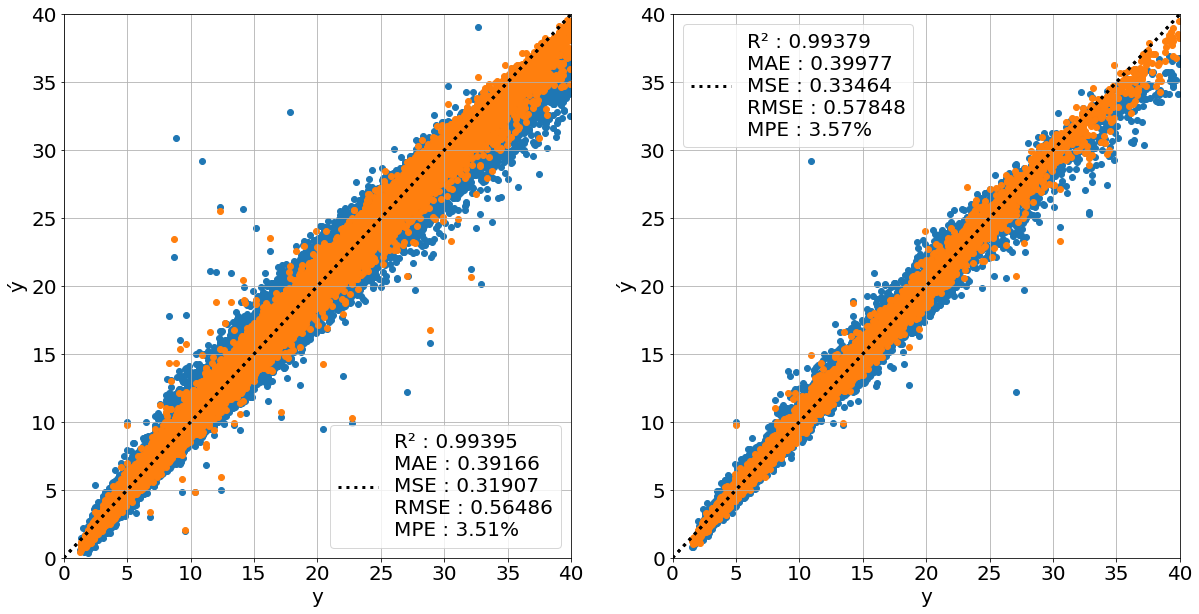

In [ ]:
#

# plot으로 모델 성능 확인

verify_plot(model, data_seen, data_unseen, parameter, xlim=[0,40], ylim=[0,40], legend=True)
verify_plot(tuned_model, data_seen, data_unseen, parameter, xlim=[0,40], ylim=[0,40], legend=True)

